In [1]:
import sys
sys.path.append('../Tools')
from IBMTools import( 
        simul,
        savefig,
        saveMultipleHist,
        printDict,
        plotMultipleQiskit,
        multResultsSim,
        setProvider,
        leastBusy,
        listBackends,
        run)
import numpy as np
import matplotlib
#matplotlib.use('nbAgg')
import matplotlib.pyplot as plt
from qiskit import( ClassicalRegister,
        QuantumRegister,
        QuantumCircuit,
        execute,
        Aer,
        IBMQ,
        transpile)
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import( plot_histogram,
                        plot_state_city,
                        plot_gate_map, 
                        plot_circuit_layout)
from math import (log,ceil)
#plt.rcParams['figure.figsize'] = 11,8
#matplotlib.rcParams.update({'font.size' : 15})
#plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline 

IBMQ.load_account()
provider = setProvider('ibm-q-minho','academicprojects','quantalab')

/home/jaime/Programming/Jaime-Santos-Dissertation/venv/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
def cnx(qc,*qubits):
    if len(qubits) >= 3:
        last = qubits[-1]
        #A matrix: (made up of a  and Y rotation, lemma4.3)
        qc.crz(np.pi/2, qubits[-2], qubits[-1])
        #cry
        qc.cu(np.pi/2, 0, 0,0, qubits[-2],qubits[-1])
        #Control not gate
        cnx(qc,*qubits[:-2],qubits[-1])
        #B matrix (cry again, but opposite angle)
        qc.cu(-np.pi/2, 0, 0,0, qubits[-2], qubits[-1])
        #Control
        cnx(qc,*qubits[:-2],qubits[-1])
        #C matrix (final rotation)
        qc.crz(-np.pi/2,qubits[-2],qubits[-1])
    #elif len(qubits)==3:
    #    qc.ccx(*qubits)
    elif len(qubits)==2:
        qc.cx(*qubits)
    return qc

In [3]:
def incrCirc(qc,q,subnode,n,toGate):
    for j in range(-1,n-1):
        if(j==-1):
            cnx(qc,subnode[0],*q[-1::-1])
        else:
            cnx(qc,subnode[0],*q[-1:j:-1])
    if toGate:
        qc = qc.to_gate()
        qc.name = '      INC      '
    return qc

def decrCirc(qc,q,subnode,n,toGate):
    qc.x(subnode[0])
    c=0
    qc.x(q[-1:0:-1])
    for j in range(-1,n-1):
        if(j==-1):
            c+=1
            cnx(qc,subnode[0],*q[-1::-1])
            qc.x(q[c])
        else:
            c+=1
            cnx(qc,subnode[0],*q[-1:j:-1])
            if(c==n):
                break
            qc.x(q[c])
    qc.x(subnode[0])
    if toGate:
        qc = qc.to_gate()
        qc.name = '      DEC      '
    return qc

In [4]:
def circRunWalk(N,steps,toGate):
    "Creates a single instance of the coined quantum walk cicuit."
    qreg = QuantumRegister(N,name='node')
    qsub = QuantumRegister(1, name='coin')
    creg = ClassicalRegister(N)
    qwc = QuantumCircuit(qreg,qsub,creg)
    incrCirc1 = QuantumCircuit(qreg,qsub)
    decrCirc1 = QuantumCircuit(qreg,qsub)
    incrCirc1 = incrCirc(incrCirc1,qreg,qsub,N,toGate)
    decrCirc1 = decrCirc(decrCirc1,qreg,qsub,N,toGate)
    qwc.x(qreg[1])
    qwc.h(qsub[0])
    qwc.barrier()
    for i in range(0,steps):
        qwc.append(incrCirc1,[N]+list(range(0,N)))
        qwc.append(decrCirc1,[N]+list(range(0,N)))
        qwc.barrier()
        if i!=steps-1:
            qwc.h(qsub[0])
    qwc.measure(qreg,creg)
    return qwc

In [5]:
def incr(qwc,q,subnode,n):
    for j in range(-1,n-1):
        if(j==-1):
            cnx(qwc,subnode[0],*q[-1::-1])
            #qwc.barrier()
        else:
            cnx(qwc,subnode[0],*q[-1:j:-1])
           # qwc.barrier()
    return qwc

def decr(qwc,q,subnode,n):
    qwc.x(subnode[0])
    c=0
    qwc.x(q[-1:0:-1])
    for j in range(-1,n-1):
        if(j==-1):
            c+=1
            cnx(qwc,subnode[0],*q[-1::-1])
            qwc.x(q[c])
            #qwc.barrier()
        else:
            c+=1
            cnx(qwc,subnode[0],*q[-1:j:-1])
            if(c==n):
                break
            qwc.x(q[c])
            #qwc.barrier()
    qwc.x(subnode[0])
    return qwc

In [6]:
def runWalk(N,steps,stateVec):
    "Creates a single instance of the coined quantum walk cicuit."
    qreg = QuantumRegister(N)
    qsub = QuantumRegister(1)
    creg = ClassicalRegister(N)
    qwc = QuantumCircuit(qreg,qsub,creg)
    qwc.x(qreg[0])
    for i in range(0,steps):
        qwc.h(qsub[0])
        qwc.barrier()
        incr(qwc,qreg,qsub,N)
        qwc.barrier()
        decr(qwc,qreg,qsub,N)
        qwc.barrier()
    if not stateVec:
        qwc.measure(qreg,creg)
    return qwc

In [7]:
print(listBackends(provider))
print(leastBusy(5,provider))

ibmq_qasm_simulator
ibmqx2
ibmq_16_melbourne
ibmq_armonk
ibmq_paris
ibmq_athens
ibmq_rome
ibmq_toronto
ibmq_santiago
ibmq_bogota
ibmq_manhattan
ibmq_casablanca
None
ibmq_paris


In [8]:
#8
melBackend = provider.get_backend('ibmq_16_melbourne')
#32QV
bogBackend = provider.get_backend('ibmq_bogota')
parisBackend = provider.get_backend('ibmq_paris')
manhatBackend = provider.get_backend('ibmq_manhattan')
torontoBackend = provider.get_backend('ibmq_toronto')
casablancaBackend = provider.get_backend('ibmq_casablanca')
#Chosen
backend = casablancaBackend
simulator = provider.get_backend('ibmq_qasm_simulator')

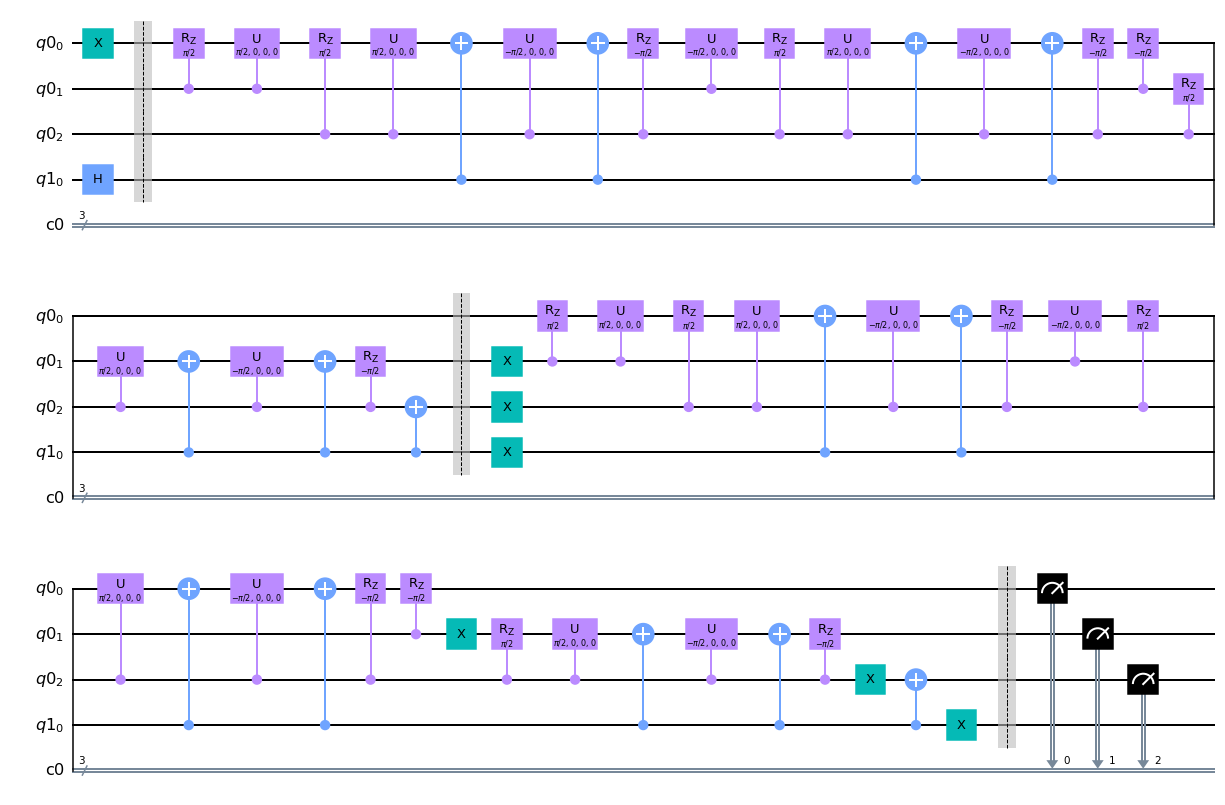

In [9]:
singleN = 3
singleSteps = 1
circ = runWalk(singleN,singleSteps,False)
init_layout = []
circTest = transpile(circ,backend=backend,optimization_level=0,layout_method='noise_adaptive')
circ.draw(output='mpl')

In [10]:
#plot_circuit_layout(circTest,backend)
noiseModel = NoiseModel.from_backend(backend)
basisGates = noiseModel.basis_gates
couplingMap = backend.configuration().coupling_map

In [19]:
circuitNoise = transpile(circ,backend=backend,layout_method='noise_adaptive',optimization_level=3)
resultNoise = execute(circuitNoise,simulator,noise_model=noiseModel,coupling_map=couplingMap,basis_gates=basisGates).result()
countsNoise = resultNoise.get_counts(circ)
print(countsNoise)

{'000': 71, '001': 82, '010': 46, '011': 59, '100': 116, '101': 289, '110': 269, '111': 92}


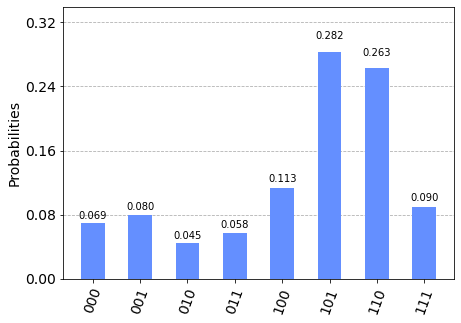

In [20]:
plot_histogram(countsNoise)

In [13]:
resultSim = execute(circ,simulator).result()
countsSim= resultSim.get_counts(circ)

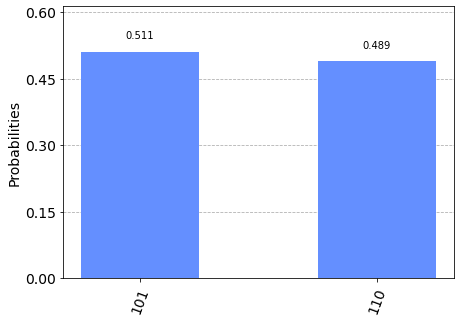

In [14]:
plot_histogram(countsSim)